In [13]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV

from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time

from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm

import pickle

In [2]:
# !pip install mlxtend
# !pip install lightgbm
# !pip install catboost
# !pip install pymysql
# !pip install scikit-plot

In [3]:
%load_ext autoreload
%autoreload 2

In [50]:
from autoscoring_bbox import IDF
from autoscoring_bbox.AS import *
from autoscoring_bbox.AS_2 import *
from autoscoring_bbox.Binning import transform_df_to_woe, construction_binning, correct_binning_dict, print_feature_bins

from autoscoring_bbox.AS_BlackBox import *

In [4]:
df = pd.read_excel('data/slkz_SolvaStreet.xlsx', sheet_name='result 1')

# Добавить, если имя целевой переменной отличается от 'target'
# df['target'] = 

df['date_requested'] = pd.to_datetime(df['date_requested'])
date_name = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df['y'] = df['target']
y = df.y

In [5]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCORE' in var or 'scoring' in var or 'street' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
# Можно задать список признаков, который не будет учавствовать в предобработке
ignore_vars = ['date_requested', 'credit_id', 'target', 'y', date_name, 'script_calculation_date']
df, else_df = replace_not_frequent_2(df, cat_vars, num_min=min_num, ignore_vars=ignore_vars)

# Drop columns with only 1 value
df = drop_single_value_column(df, except_cols=ignore_vars)

In [9]:
# Если вы не разделяете сэмпл на df_out, то можете закомментировать этот кусок,
# и вместо него запустить:
# df_out, y_out = None, None

split_date = '2021-01-01'
df_out = df[df[date_name] >= split_date]
df = df[df[date_name] < split_date]
y_out = df_out.y

In [10]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.2, stratify=df.y, random_state=123)

#### Первичный отбор признаков по IV

In [9]:
# Задаём набор признаков для формирования биннинга.
# Набор колонок, который не будет учавствовать в построении карты
technical_features = ['credit_id', 'date_requested', 'type',
                        'target', 'y']
# Задаём набор признаков, которые будут учавствовать в биннинге,
# для этого удаляем все ненужные признаки из общего списка переменных.
features = df_train.drop(
    technical_features
, axis=1).columns

target_name = 'target'  # Наименование столбца - таргета
# Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# только в исключительных ситуациях
min_bin_size = 0.05
max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# Как определять WOE для пропусков, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
nan_to_woe = 'max_cat'
# Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
else_to_woe = 'max_cat'
# Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
monotonic = True
n_jobs = 3  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df_train, features, target_name,
                                                         max_bin_count=max_bin_count,
                                                         min_bin_size=min_bin_size,
                                                         nan_to_woe=nan_to_woe,
                                                         else_to_woe=else_to_woe,
                                                         monotonic=monotonic,
                                                         n_jobs=n_jobs)

# iv_df - таблицы WOE биннинга
# dropped_feats - набор переменных, для которых биннинг не посчитался,
# т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный,
# также стоит отдельно смотреть, что может быть такая ситуация, что переменная не имеет хорошего 
# разделения, но NaN значения хорошо отделяются. Тогда стоит отдельно заполнять NaN некоторым эмпирическим значением.
# feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# по которым признак не очень хороший, можно игнорировать
# best_features - набор признаков после предварительного отбора внутри AutoML,
# можно использовать при дальнейшем отборе, можно проигнорировать
# auto_woe - техническая переменная, можно игнорировать

[LightGBM] [Info] Number of positive: 474, number of negative: 5268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19198
[LightGBM] [Info] Number of data points in the train set: 5742, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082550 -> initscore=-2.408199
[LightGBM] [Info] Start training from score -2.408199
ERROR in last days_from_fc_d_requested doesnt have information, [-2.235e+02  1.000e-05], 1


In [9]:
# iv_df.to_excel('result/iv_df.xlsx')

In [11]:
iv_df = pd.read_excel('result/iv_df.xlsx', index=0)

In [12]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.02
iv_feat = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()
print(len(iv_feat))

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(iv_feat)]

109


In [16]:
X_train, X_test, X_out = df_train[iv_feat], df_test[iv_feat], df_out[iv_feat]

cat_feat = df[iv_feat].select_dtypes(include=object).columns
num_feat = df[iv_feat].select_dtypes(exclude=object).columns

#### Предобработка данных

In [17]:
# Заполнение пропусков для непрерывных в данных

# Определяем значения для каждого конкретного столбца для заполнения пропусков NaN.
nan_custom = {
    'cnt_IL_all': 5,
}
# Указываем способ заполнения пропусков для отсальных признаков.
# 'median' - заполнение медианным значением
# 'max_freq' - заполнение значением с наибольшей частотой
# 'constant' - заполнение константой, при этом надо указать эту константу
#       в параметре fill_value
# 'auto_iv' - заполнение афтоматически, исходя из подходящих бинов в WOE таблице,
#       при этом надо указать параметр iv_df
nan_imputer = 'auto_iv'

nan_encoding = fit_nan_encoding(df_train, num_feat, nan_imputer, nan_custom, iv_df=iv_df)

In [18]:
X_train = transform_nan_encoding(X_train, num_feat, nan_encoding)
X_test = transform_nan_encoding(X_test, num_feat, nan_encoding)
X_out = transform_nan_encoding(X_out, num_feat, nan_encoding)

In [19]:
cat_encoding = fit_category_encoding(df_train, cat_feat, encoding_type='target_encoding')

X_train = transform_category_encoding(X_train, cat_feat, cat_encoding)
X_test = transform_category_encoding(X_test, cat_feat, cat_encoding)
X_out = transform_category_encoding(X_out, cat_feat, cat_encoding)

In [19]:
# На практике StandartScaler не всегда дает какой-то прирост, 
# поэтому он необязателен. Можно использовать по желанию.

# transforamtion = fit_transformation(X_train, iv_feat, type='standart_scaler')

# X_train = apply_transformation(X_train, iv_feat, transforamtion)
# X_test = apply_transformation(X_test, iv_feat, transforamtion)
# X_out = apply_transformation(X_out, iv_feat, transforamtion)

In [20]:
# Сохраним методы предобработки данных

with open('result/preprocessing.pkl', 'wb') as file:
    pickle.dump([nan_encoding, cat_encoding], file)

#### Отбор признаков

In [ ]:
# TODO: Посмотреть автоматич методы отбора признаков.
# Библиотека featurewiz, feature-engine
# TODO: Мб сделать gini_month_selection но на основе разных моделей, 
# например на основе неглубокого дерева решений.

In [21]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по DATE (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества интервалов большего num_bad_intervals.
# Т.е. например, если gini_min=0.05 и num_bad_intervals=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.05  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_intervals = 2  # 2 месяца/недели по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
# date_name =   # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week

gini_feats, df_gini_months = gini_month_selection(X_train, df_train, gini_min=gini_min,
                                                  num_bad_intervals=num_bad_intervals, date_name=date_name,
                                                  intervals=intervals)

In [22]:
print(len(list(gini_feats)))
df_gini_months[df_gini_months['vars'].isin(gini_feats)]

54


,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,days_from_fc_d_requested,0.045,0.018,0.083,0.116,0.060,0.122,0.099,0.133
1,credits_active_owner,-0.009,0.126,0.201,0.151,0.238,0.094,0.205,0.191
2,credits_all_owner,0.099,0.019,0.328,0.200,0.241,0.286,0.299,0.383
3,monthly_instalments_owner,-0.066,0.074,0.164,0.249,0.338,0.122,0.242,0.277
4,mnt_outstand_balance,-0.055,-0.041,0.094,0.187,0.308,0.147,0.245,0.239
8,act_div_all_crd,0.137,0.134,0.138,0.102,0.020,0.266,0.114,0.317
13,fc_credits_active_owner,-0.009,0.126,0.201,0.151,0.238,0.094,0.205,0.191
14,fc_credits_all_owner,0.099,0.019,0.328,0.200,0.241,0.286,0.299,0.383
15,fc_monthly_instalments_owner,-0.066,0.074,0.164,0.249,0.338,0.122,0.242,0.277
16,fc_mnt_outstand_balance,-0.055,-0.041,0.094,0.187,0.308,0.147,0.245,0.239


Здесь два дополнительных отбора, для того чтобы сразу выбрать только признаки со стабильной разделющей способностью.

In [24]:
# Считаем однофакторный gini для train, test, out.
# И на основе этих значений удаляем нестабильные признаки.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, gini_feats)
gini_by_vars = gini_univariate_selection(gini_by_vars, cut_off=0.6)
gini_feats = gini_by_vars['vars'].values

print(len(gini_feats))

In [25]:
# Считаем средние значения WOE по каждому признаку для значений таргета 0 и 1,
# чем больше их разница, тем по логике лучше разделяющая способность признака.
# Потом удаляем нестабильные признаки, у которых значения сильно изменяеются для train/test/out.
df_woe_diff = calc_woe_target_differences(X_train, X_test, X_out, y_train, y_test, y_out, gini_feats)
df_woe_diff = woe_univariate_selection(df_woe_diff, cut_off=0.6)
woe_feats = df_woe_diff['vars'].values

print(len(woe_feats))

36


Если на данном этапе осталось достаточно много признаков (60+), то можно воспользоваться методами отбора <b>rf_feature_selection</b> и/или <b>permutation_two_forest_selection</b>. \
Но это не обязательно

In [22]:
# Отбираем признаки по их значимости во время построения Деревьев решений.
top_n = 55  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
rf_feats, rf_imp = rf_feature_selection(X_train[gini_feats], y_train, top_n=top_n)

In [23]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 35  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
tf_feats, tf_imp = permutation_two_forest_selection(X_train[rf_feats], y_train, top_n=top_n)

Итоговый отбор методом Recursive Feature Elimination с использованием CatBoosting модели.

In [30]:
# variables = tf_feats
variables = woe_feats

In [31]:
feat_to_del = []  # Здесь указать признаки, которые точно стоит удалить.

feat_for_cat_select = list(set(variables) - set(feat_to_del))

In [32]:
# iterations - кол-во моделей в бустинге
# depth - глубина деревьев
# min_data_in_leaf - минимальный набор данных в одном листе дерева
# num_features - сколько признаков тербуется на выходе
# steps - кол-во итераций отбора, должно былть меньше, чем num_features

cat_params = {'eval_metric': 'AUC', 'iterations': 500, 'depth': 6,
              'min_data_in_leaf': 1000, 'random_seed': 0}
num_features = 15
steps = 10

cat_feats = catboost_feat_selection(X_train, X_test, y_train, y_test,
                                    feat_for_cat_select, cat_params=cat_params,
                                    num_features=num_features, steps=steps)

In [34]:
vars = cat_feats
print(vars)

['bor_age', 'credits_all_owner', 'monthly_instalments_owner', 'requested_credit_count_days', 'fc_monthly_instalments_owner', 'fcb_first_cred_open', 'fcb_first_cred_open_act', 'pti7', 'NumberOfOverdueInstalmentsMax', 'reg', 'cnt_IL_comp', 'r_reg', 'cnt_IL_all', 'cnt_IL_comp_no_Crd', 'cnt_IL_all_no_Crd']


#### Обучение модели, требуется выбрать одну из них, а остальные закомментировать. Можно добавить свои модели.

In [35]:
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [36]:
df_train_m = X_train[vars]
df_test_m = X_test[vars]
df_out_m = X_out[vars]

# params = {
#     'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
#     'class_weight': {0: 1, 1: 4}, 'random_state': 142
# }
# # Обучаем модель на данных полученных после удаления аномалий.
# logreg = LogisticRegression(**params).fit(df_train_m, y_train)

params = {
    'n_estimators': 100, 'max_depth': 4,
    'class_weight': {0: 1, 1: 3}, 'random_state': 142,
    'feature_fraction': 0.5, 'bagging_fraction': 0.5,
    'bagging_freq': 10, 'num_leaves': 10,
    'learning_rate': 0.02, # 'min_data_in_leaf': 500
    'verbose': -1,
}
model = lgb.LGBMClassifier(**params)

# lgb_train = lgb.Dataset(df_train_m, y_train, params={'verbose': -1}, free_raw_data=False)
# model = lgb.train({'verbose': -1}, lgb_train, verbose_eval=False)

# params = {
#     'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 100,
#      'min_samples_leaf': 80, 'max_features': "auto", 'random_state': 142
# }
# model = RandomForestClassifier(**params, )

# from mlxtend.classifier import StackingClassifier
# model = StackingClassifier(
#     classifiers=[
#         LogisticRegression(),
#         lgb.LGBMClassifier(**params)
#     ],
#     use_probas=True,
#     meta_classifier=LogisticRegression()
# )

model.fit(df_train_m, y_train)

predict_proba_train = model.predict_proba(df_train_m)[:, 1]
predict_proba_test = model.predict_proba(df_test_m)[:, 1]
predict_proba_out = model.predict_proba(df_out_m)[:, 1]

Gini_train = round(2 * roc_auc_score(y_train, predict_proba_train) - 1, 3)
Gini_test = round(2 * roc_auc_score(y_test, predict_proba_test) - 1, 3)
Gini_out = round(2 * roc_auc_score(y_out, predict_proba_out) - 1, 3)

print('---------------------------------------------------------------------------------------------')
print('| Gini train =', Gini_train, '| Gini test =', Gini_test,  '| Gini out =', Gini_out, '|')
print('---------------------------------------------------------------------------------------------')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
---------------------------------------------------------------------------------------------
| Gini train = 0.525 | Gini test = 0.418 | Gini out = 0.429 |
---------------------------------------------------------------------------------------------


In [37]:
# Сохраняем итоговую мдель и набор признаков в pickle.
with open('result/model_vars.pkl', 'wb') as file:
    pickle.dump([model, vars], file)

In [38]:
# Считаем важность признаков в модели
tmp = pd.DataFrame([vars, model.feature_importances_]).T
tmp.columns = ['feature', 'mean_imp']
feature_importance = tmp.sort_values(by='mean_imp', ascending=False)

display(feature_importance)

,feature,mean_imp
6,fcb_first_cred_open_act,111
7,pti7,105
0,bor_age,87
5,fcb_first_cred_open,83
4,fc_monthly_instalments_owner,67
2,monthly_instalments_owner,64
3,requested_credit_count_days,64
11,r_reg,60
12,cnt_IL_all,51
8,NumberOfOverdueInstalmentsMax,48


In [ ]:
# Можно так же оценить вжаность полученных прзнаков в модели по premutation importance
# df_perm_imp = calc_permutation_importance(model, X_test[vars_woe], y_test, n_repeats=50, n_jobs=3)
# df_perm_imp

Этапы для удаления / добавления признаков по одному. Можно дополнительно посмотреть, как измениться качество модели. На практике это необязательно, но может быть полезно

In [41]:
# Здесь требуется последовательно указать train, test, out выборки,
# если out - отсутствует, поставить None.
# При этом стоит указать не все признаки, а набор признаков после
# предварительного отбора - rf_feats, gini_feats
X_all = [X_train[feat_for_cat_select], X_test[feat_for_cat_select], X_out[feat_for_cat_select]]
y_all = [y_train, y_test, y_out]

# Набор признаков, который оценить при удалении.
# В качестве кандидаотв берем топ10 с конца по важности.
vars_to_exclude = feature_importance.iloc[-10:]['feature'].values

# Считаем, что будет, если убрать один из признаков.
# Напротив каждого признака - gini модели после удаления этого признака.
df_var_ginis = feature_exclude_bbox(X_all, y_all, list(vars), list(vars_to_exclude), iv_df, model)
df_var_ginis.sort_values(by='gini_test', ascending=False)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

,var_name,gini_train,gini_test,gini_out,IV
1,monthly_instalments_owner,0.524074,0.42741,0.436271,0.1408
6,reg,0.523079,0.424075,0.437114,0.0777
8,cnt_IL_comp,0.524119,0.421287,0.430070,0.2469
7,credits_all_owner,0.523385,0.420626,0.438210,0.2472
10,cnt_IL_comp_no_Crd,0.519189,0.420401,0.442484,0.2337
4,cnt_IL_all,0.522292,0.419853,0.444346,0.2758
0,with all,0.525176,0.418089,0.429389,
5,NumberOfOverdueInstalmentsMax,0.519016,0.416929,0.420491,0.1507
9,cnt_IL_all_no_Crd,0.51965,0.415237,0.441944,0.233
3,r_reg,0.520952,0.41402,0.415070,0.0987


In [42]:
# Считаем, что будет, если добавить один из признаков.
# Напротив каждого признака - gini модели после добавления этого признака.
df_var_ginis = feature_include1_bbox(X_all, y_all, vars, iv_df, model)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

,var_name,gini_train,gini_test,gini_out,IV
19,fc_h_cl_sum_div_days,0.534765,0.439479,0.431471,0.0849
12,dependants_count,0.531357,0.42774,0.438946,0.0433
18,days_from_fc_d_requested,0.536235,0.423003,0.457840,0.0421
15,mnt_outstand_balance,0.530515,0.422463,0.427553,0.1297
1,fc_mnt_outstand_balance,0.530515,0.422463,0.427553,0.1297
20,act_div_all_crd,0.52559,0.42231,0.431582,0.1428
8,fc_act_div_all_crd,0.52559,0.42231,0.431582,0.1428
11,sex,0.538011,0.420578,0.437019,0.0924
2,cnt_IL_act_no_Crd,0.52522,0.420014,0.431534,0.0458
4,kaspi_completed,0.524498,0.419861,0.428728,0.1129


#### Построение графиков и таблиц для оценки результатов

In [43]:
_X = np.vstack([X_train[vars], X_test[vars], X_out[vars]])
_y = np.hstack([y_train, y_test, y_out])

_model = deepcopy(model)
scores = list(map(lambda x: round(x, 3), 2 * cross_val_score(_model, _X, _y, cv=5, scoring='roc_auc') - 1))
print ('Cross_val_scores: ', scores)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

In [45]:
date_name = date_name  # имя столбца даты по которому делить на месяцы
intervals = 'month'  # грануляция по времени, возможно month и week

df3 = construct_df3_bbox(vars, model, X_train, X_test, df_train, df_test,
                         X_out=X_out, df_out=df_out, date_name=date_name, intervals=intervals)

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

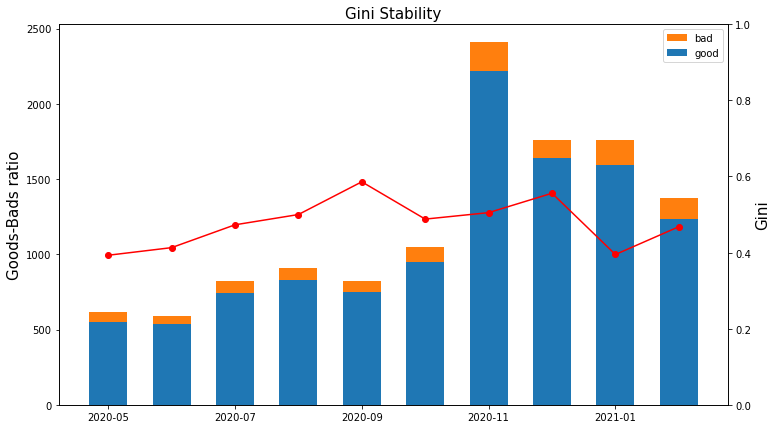

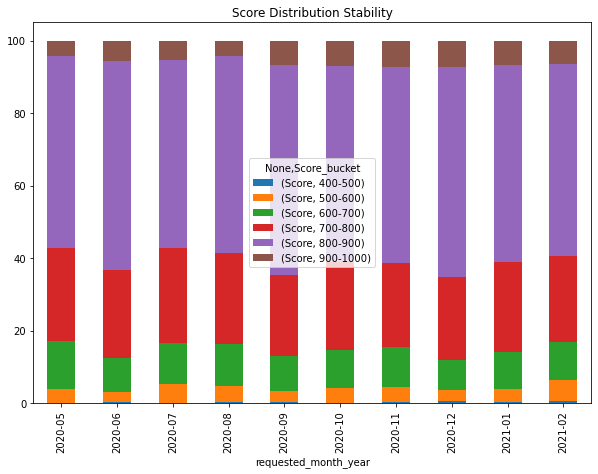

In [48]:
Ginis = create_gini_stability(df3, model, X_train[vars])

pic_folder = 'pic/'  # Папка, в которую сохранятся картинки, надо отдельно создать её.
period_date = 2  # Период с которым будут отображаться даты на графике
gini_stability_chart(Ginis, pic_folder=pic_folder, period_date=period_date)
score_stability_graph(table, pic_folder=pic_folder)

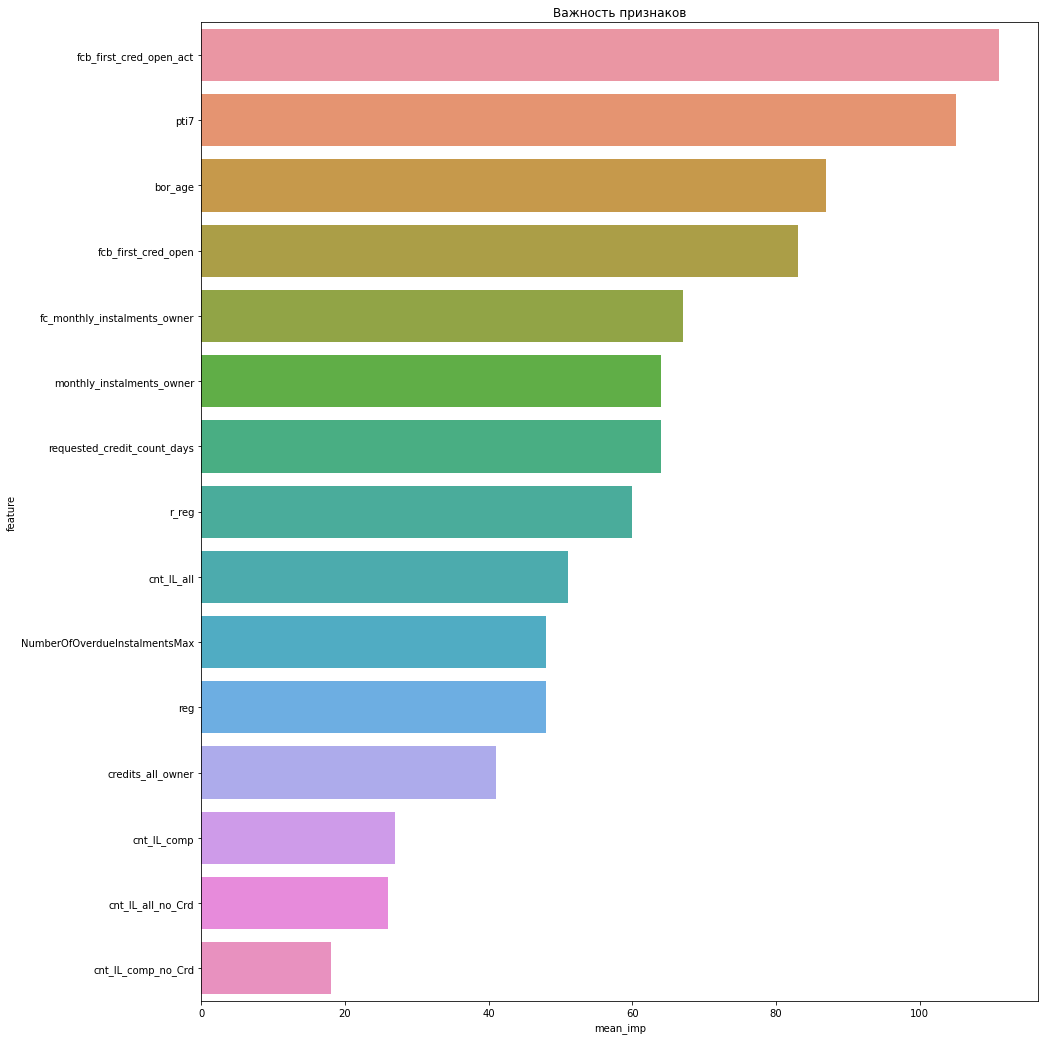

In [51]:
# feature_importance = tf_imp[tf_imp['feature'].isin(vars)]
feat_imp_parts = plot_feature_importances(feature_importance, pic_folder=pic_folder)

In [27]:
# # Можно отдельно посчитать SHAP значения - какой вклад каждый признак вносит
# # в итоговый результат.
# # Можно пропустить, это не критично.
# # Я устанавливал этой командой:
# # !conda install -c conda-forge shap

# import shap
# # TODO: сохранять это как картинки и потом в отчет добавлять.

# explainer = shap.Explainer(model.predict, X_test[vars])
# shap_values = explainer(X_test[vars])

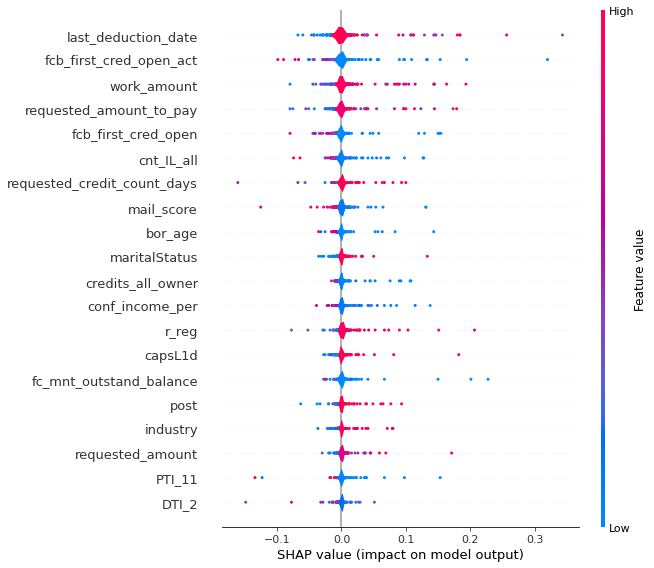

In [46]:
# fig = shap.summary_plot(shap_values, plot_type='violin', show=False)
# plt.savefig(pic_folder + 'shap_violin.png', bbox_inches='tight')

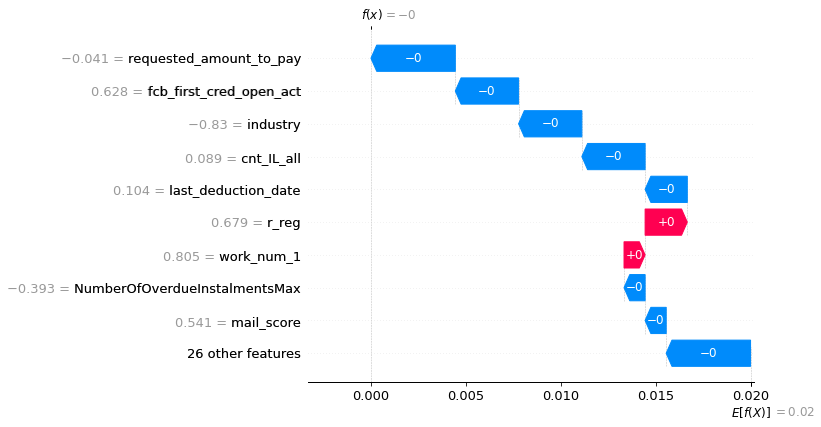

In [47]:
# fig = shap.plots.waterfall(shap_values[0], show=False)
# plt.savefig(pic_folder + 'shap_waterfall.png', bbox_inches='tight')

In [52]:
# Считаем однофакторный gini по месяцам.
date_name = 'date_requested'  # Дата, по которой делить на месяцы.
_, df_gini_months = gini_month_selection(df3[vars], df3, date_name=date_name)
df_gini_months

In [53]:
# Считаем однофакторный gini для train, test, out.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, vars)
gini_by_vars

,vars,gini_train,gini_test,gini_out
12,cnt_IL_all,0.279,0.304,0.323
10,cnt_IL_comp,0.271,0.284,0.314
1,credits_all_owner,0.264,0.274,0.311
13,cnt_IL_comp_no_Crd,0.264,0.287,0.314
14,cnt_IL_all_no_Crd,0.263,0.282,0.313
5,fcb_first_cred_open,0.205,0.255,0.274
0,bor_age,0.204,0.208,0.246
2,monthly_instalments_owner,0.2,0.221,0.202
4,fc_monthly_instalments_owner,0.2,0.221,0.202
8,NumberOfOverdueInstalmentsMax,0.185,0.209,0.256


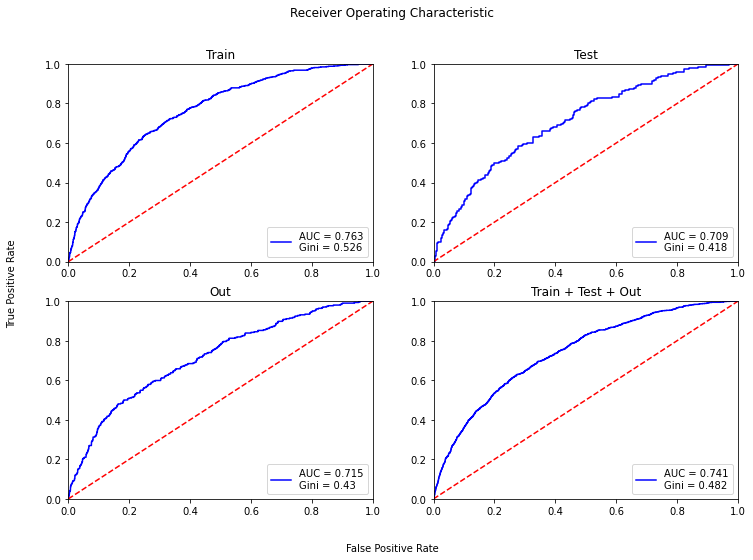

In [54]:
X_all = df3.copy()
y_all = df3['target'].copy()

plot_roc_curve(model, vars, X_all, y_all, X_train, y_train, X_test, y_test,
                 X_out, y_out, pic_folder=pic_folder)

In [124]:
# # Отрисовка PSI признаков
# # Можно по желанию добавить
# new_df = create_bins_from_df(df3, vars, n_jobs=4)

# month_num = 5
# plot_psi_scores(new_df, vars, month_num=month_num, pic_folder=pic_folder)

,credit_id,date_requested,target,last_deduction_date,cnt_IL_all,requested_amount_to_pay,credits_all_owner,cnt_IL_comp,PTI_11,industry,...,post,requested_annuity_amount,mnt_outstand_balance,work_num_1,min_IL_planned_close_date_no_Crd,employment,requested_month_year,PD,Score,Score_bucket
0,2430290,2020-11-30 12:27:49,0.0,"(-0.348, -0.0349]","(-0.0304, 0.0209]","(1.184, 2.019]","(-0.22, 0.168]","(-0.048, 0.0186]","(-0.0638, -0.0548]","(-1.143, -0.83]",...,"(0.437, 1.327]","(1.163, 11.978]","(-0.522, -0.396]","(-0.967, -0.399]","(1.15, 1.909]","(-1.944, -0.683]",2020-11,0.202706,797.0,700-800
1,2466149,2020-12-23 10:27:56,0.0,"(-0.662, -0.591]","(-0.168, -0.116]","(-0.98, -0.7]","(-1.128, -0.868]","(-0.16, -0.137]","(-0.0638, -0.0548]","(-0.83, 0.232]",...,"(0.437, 1.327]","(-1.2349999999999999, -0.875]","(-0.578, -0.522]","(0.534, 2.989]","(-12.863999999999999, -0.678]","(-0.683, 1.13]",2020-12,0.241183,759.0,700-800
2,2275627,2020-09-02 14:58:36,0.0,"(-0.591, -0.348]","(0.0894, 84.168]","(-0.331, 0.31]","(0.816, 13.643]","(0.107, 83.959]","(-0.0522, -0.0498]","(0.375, 0.707]",...,"(-0.919, 0.437]","(0.13, 1.163]","(-0.064, 0.373]","(-0.399, 0.534]","(-12.863999999999999, -0.678]","(-0.683, 1.13]",2020-09,0.117285,883.0,800-900
3,2131949,2020-06-01 15:17:56,0.0,"(-0.591, -0.348]","(-0.0304, 0.0209]","(0.31, 1.184]","(-0.22, 0.168]","(-0.048, 0.0186]","(-0.0415, -0.0249]","(-1.143, -0.83]",...,"(0.437, 1.327]","(-0.232, 0.13]","(-0.396, -0.255]","(-0.967, -0.399]","(0.602, 1.15]","(-0.683, 1.13]",2020-06,0.149004,851.0,800-900
4,2137034,2020-06-05 11:38:05,0.0,"(-0.662, -0.591]","(-0.0304, 0.0209]","(-0.98, -0.7]","(-0.22, 0.168]","(0.0186, 0.107]","(-0.0548, -0.0522]","(-2.6029999999999998, -1.143]",...,"(-0.919, 0.437]","(-1.2349999999999999, -0.875]","(-0.396, -0.255]","(-0.399, 0.534]","(-12.863999999999999, -0.678]","(-1.944, -0.683]",2020-06,0.113195,887.0,800-900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12102,2485034,2021-01-06 17:37:05,0.0,"(0.348, 5.738]","(-0.0304, 0.0209]","(-0.331, 0.31]","(-0.22, 0.168]","(0.0186, 0.107]","(-0.0638, -0.0548]","(0.232, 0.375]",...,"(0.437, 1.327]","(0.13, 1.163]","(-0.578, -0.522]","(-0.399, 0.534]","(-12.863999999999999, -0.678]","(-0.683, 1.13]",2021-01,0.261933,738.0,700-800
12103,2561219,2021-02-17 13:39:41,0.0,"(-0.662, -0.591]","(-0.0304, 0.0209]","(0.31, 1.184]","(-0.22, 0.168]","(-0.048, 0.0186]","(-0.0548, -0.0522]","(0.232, 0.375]",...,"(-0.919, 0.437]","(-0.232, 0.13]","(-0.578, -0.522]","(0.534, 2.989]","(1.15, 1.909]","(-1.944, -0.683]",2021-02,0.143249,857.0,800-900
12104,2547209,2021-02-10 14:43:06,0.0,"(-0.662, -0.591]","(-0.168, -0.116]","(-0.331, 0.31]","(-1.128, -0.868]","(-0.16, -0.137]","(-0.0548, -0.0522]","(0.232, 0.375]",...,"(0.437, 1.327]","(-0.643, -0.232]","(-0.396, -0.255]","(-0.399, 0.534]","(-12.863999999999999, -0.678]","(-1.944, -0.683]",2021-02,0.188283,812.0,800-900
12105,2519349,2021-01-26 12:17:34,0.0,"(-0.662, -0.591]","(-0.116, -0.0818]","(0.31, 1.184]","(-0.868, -0.609]","(-0.0924, -0.048]","(-0.0548, -0.0522]","(0.232, 0.375]",...,"(0.437, 1.327]","(0.13, 1.163]","(-0.255, -0.064]","(-0.399, 0.534]","(-12.863999999999999, -0.678]","(-1.944, -0.683]",2021-01,0.219027,781.0,700-800


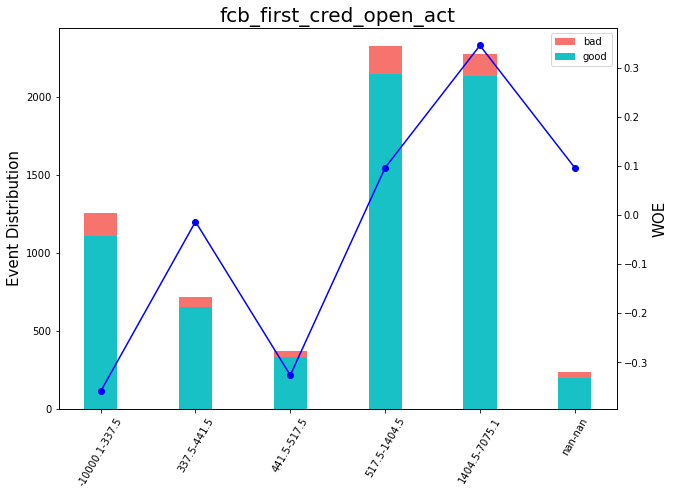

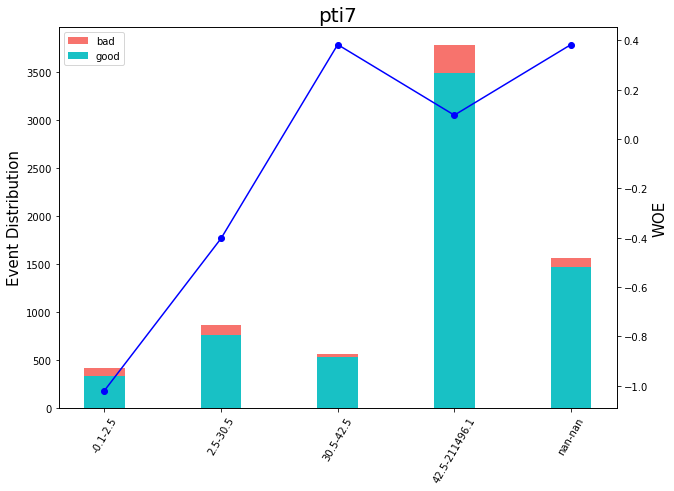

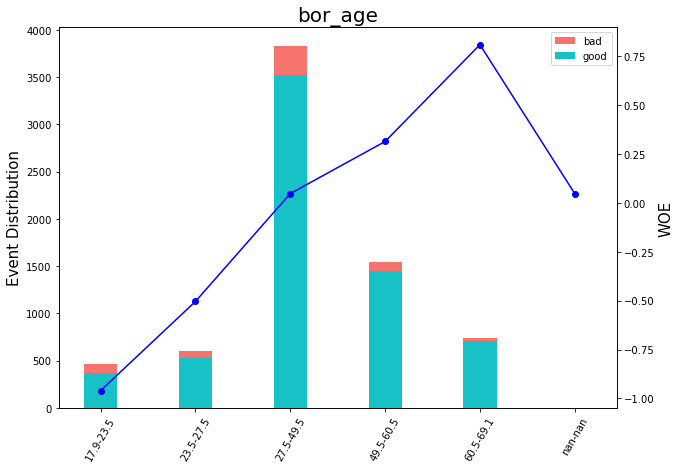

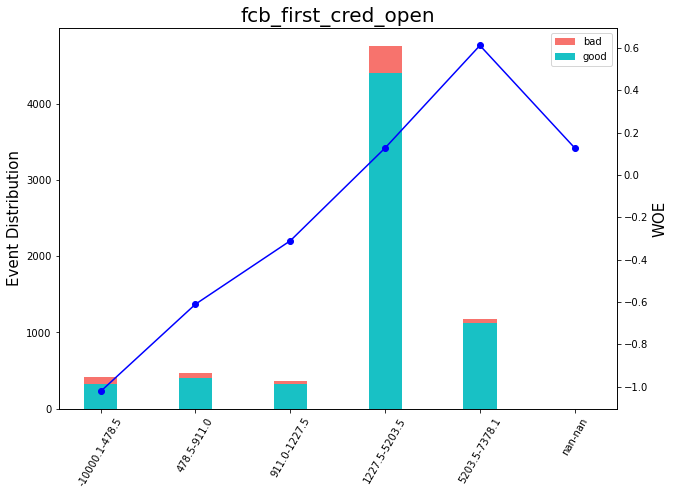

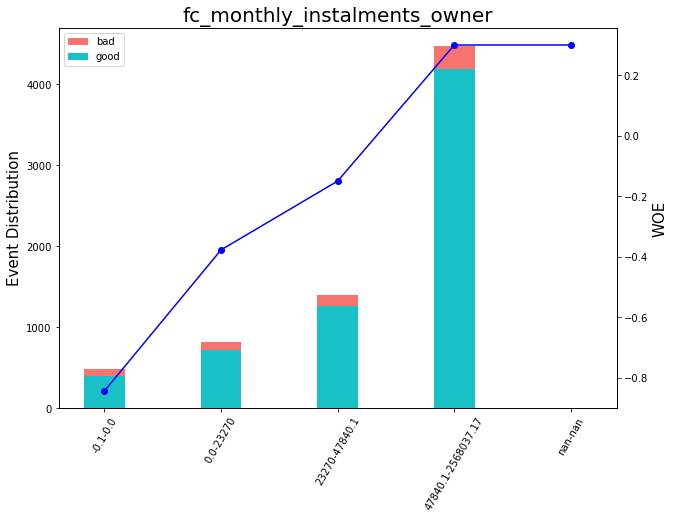

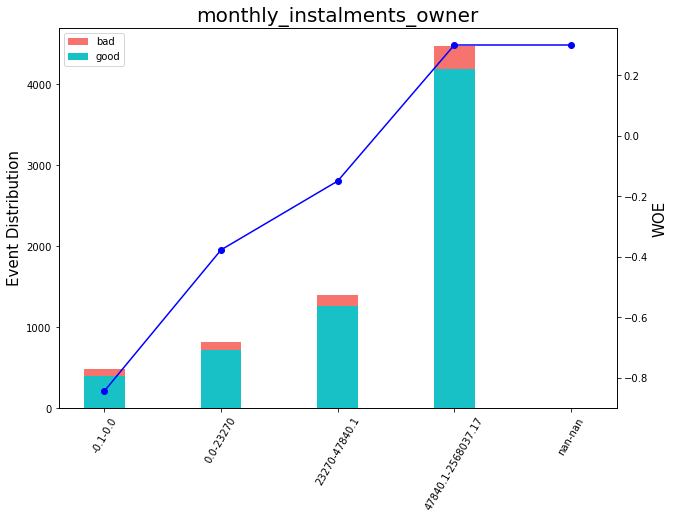

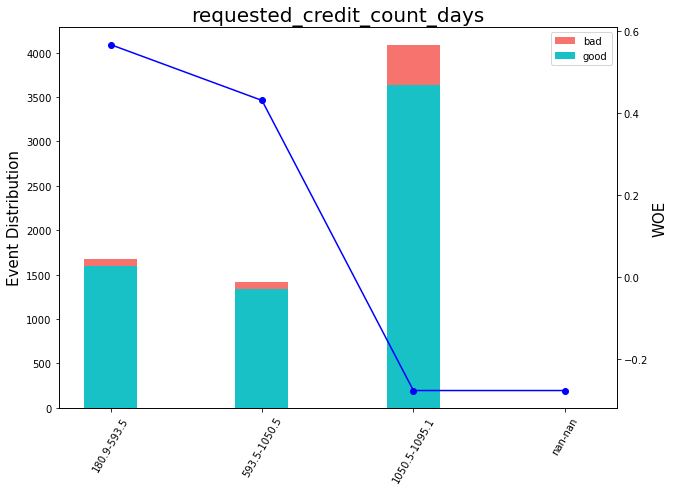

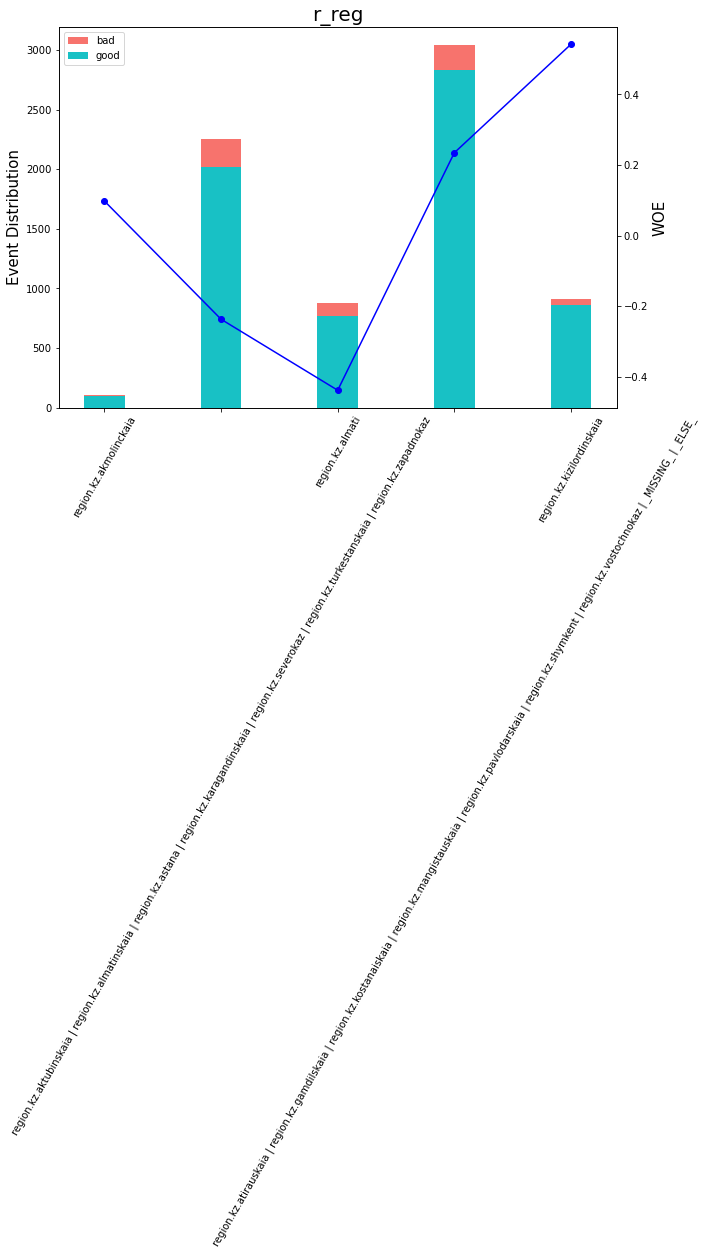

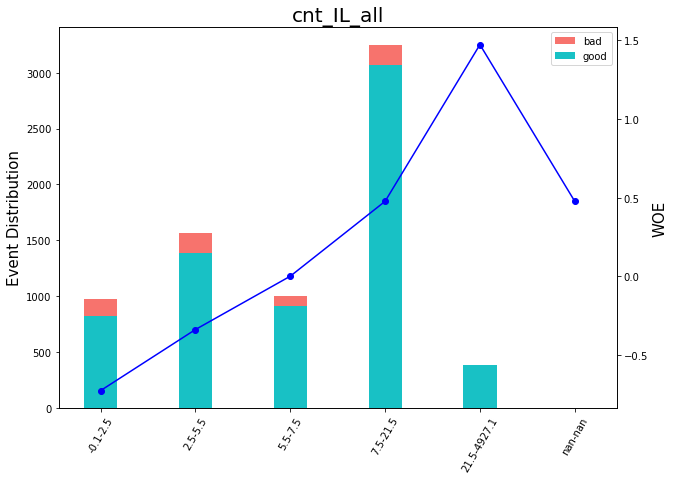

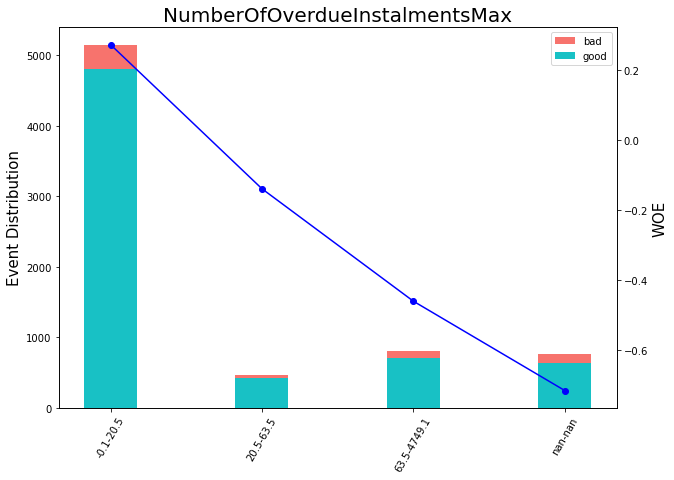

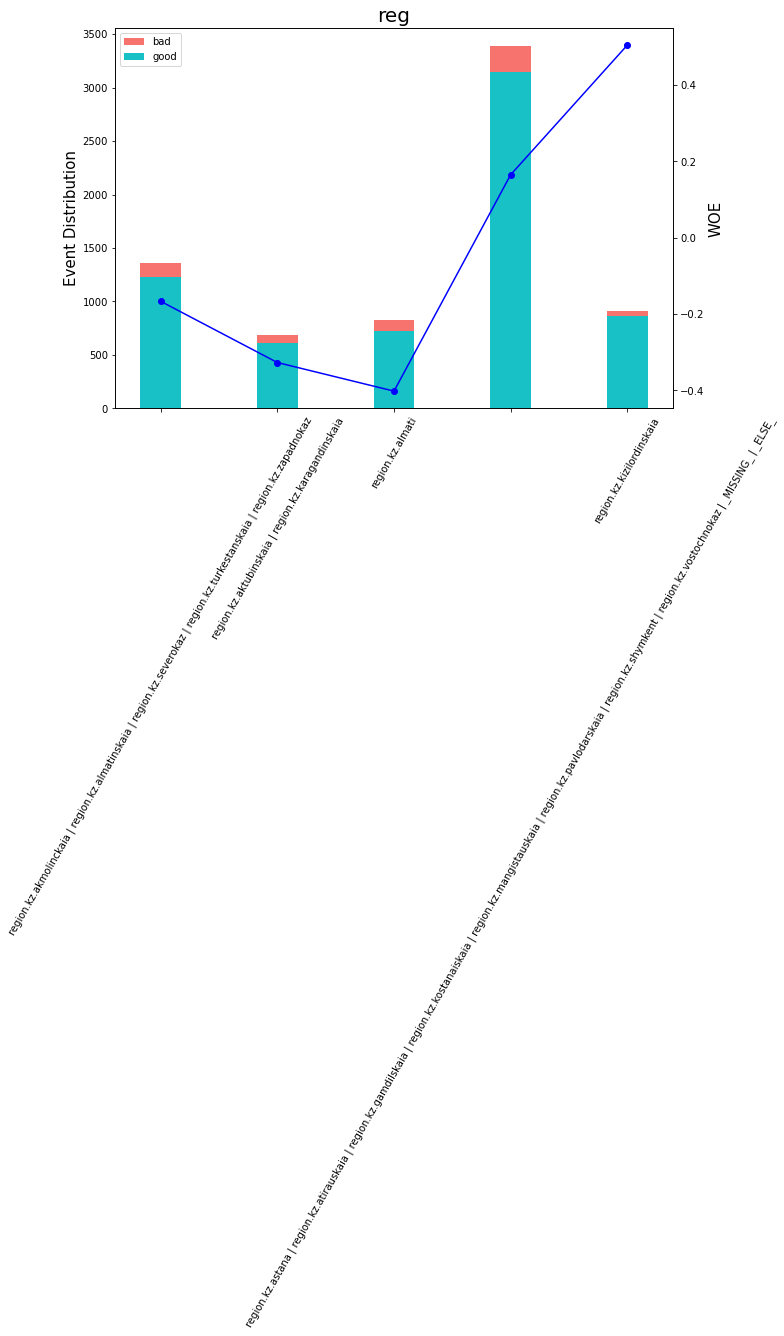

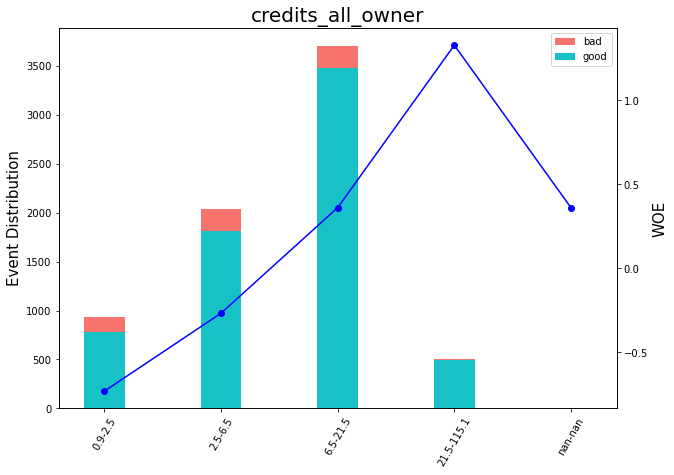

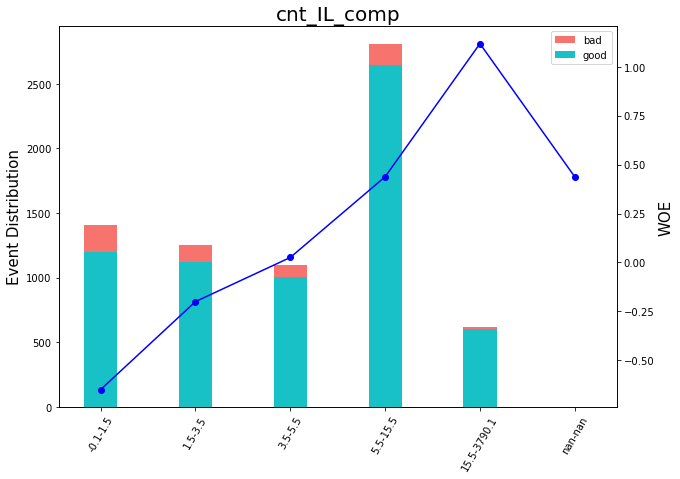

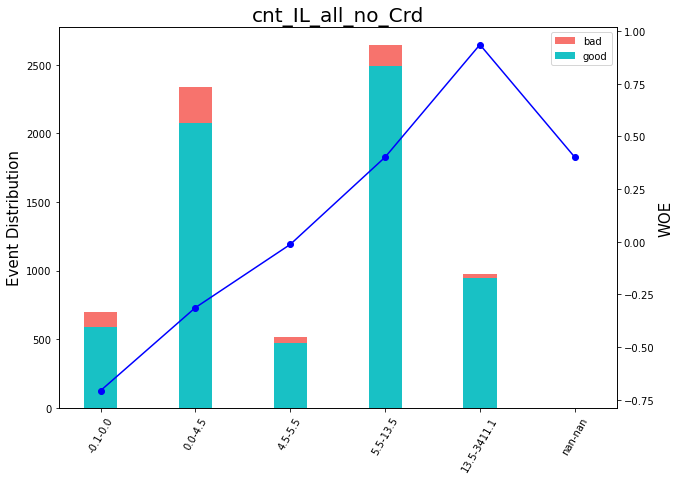

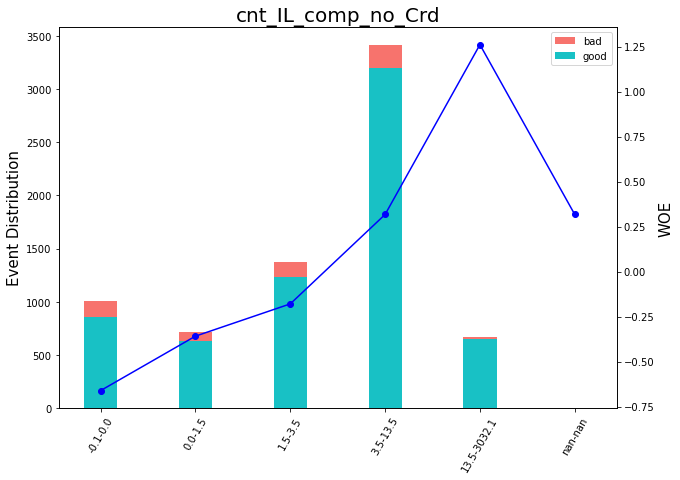

In [55]:
# Отрисуем графики с WOE биннингом в порядке уменьшения важности признаков.
# Будет полезно посмотреть на логику отдельных признаков.
vars_sorted = feature_importance['feature'].values
plot_all_bins(iv_df, X_train[vars_sorted], pic_folder=pic_folder)

In [56]:
target_description = 'npl1_3mob'
model_description = 'Скоркарта SLKZ Street'

name_2 = 'report/slkz_solvaStreet_score_v1.1'

export_to_excel_bbox(
    X_train=X_train[vars],
    X_test=X_test[vars],
    y_train=y_train,
    y_test=y_test,
    y=y,
    df3=df3.head(1000),
    iv_df=iv_df,
    Ginis=Ginis,
    table=table,
    scores=scores,
    feat=vars,
    clf_lr=model,
    df_gini_months=df_gini_months,
    gini_by_vars=gini_by_vars,
    X_out=X_out[vars],
    y_out=y_out,
    name=name_2,
    pic_folder='pic/',
    target_description=target_description,
    model_description=model_description,
    date_name=date_name,
    vars_sorted=feature_importance['feature'].values
)

Exported!
